<a href="https://colab.research.google.com/github/DevanshD3/OpenCV-1/blob/master/ChessBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import torch
from torch import optim,nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
import helper
import importlib
importlib.reload(helper)


--2020-07-07 07:40:45--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2020-07-07 07:40:46 (43.8 MB/s) - ‘helper.py’ saved [2813/2813]



<module 'helper' from '/content/helper.py'>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
data_dir = '/content/gdrive/My Drive/RoManOV'
transform = transforms.Compose([transforms.Resize(225),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle= True)


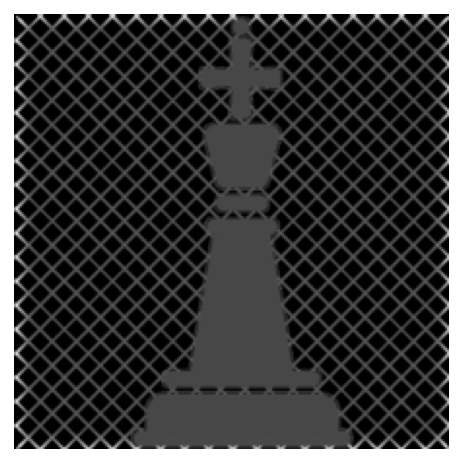

In [ ]:
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize = False) 
#if it shows an error just run it 2 or 3 times error goes off


In [ ]:
data_dir = '/content/gdrive/My Drive/RoManOV'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize(225),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir +'/train', transform = train_transforms)
test_data = datasets.ImageFolder(data_dir +'/test', transform = test_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16)

In [ ]:
model = models.densenet121(pretrained=False)
# model

In [ ]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [ ]:
import time
# export CUDA_VISIBLE_DEVICES=0
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Device = cpu; Time per batch: 0.943 seconds
Device = cuda; Time per batch: 0.008 seconds


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [ ]:

epochs = 10
steps = 0
running_loss = 0
print_every = 10
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            epoch = epoch + 1
            running_loss = 0
            model.train()

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 2/10.. Train loss: 0.594.. Test loss: 0.761.. Test accuracy: 0.438
Epoch 3/10.. Train loss: 0.595.. Test loss: 0.770.. Test accuracy: 0.438
Epoch 4/10.. Train loss: 0.618.. Test loss: 0.784.. Test accuracy: 0.438
Epoch 5/10.. Train loss: 0.757.. Test loss: 0.749.. Test accuracy: 0.438
Epoch 7/10.. Train loss: 0.601.. Test loss: 0.736.. Test accuracy: 0.438
Epoch 8/10.. Train loss: 0.607.. Test loss: 0.753.. Test accuracy: 0.438
Epoch 9/10.. Train loss: 0.627.. Test loss: 0.773.. Test accuracy: 0.438
Epoch 10/10.. Train loss: 0.718.. Test loss: 0.762.. Test accuracy: 0.438
